#### Setup imports

In [34]:
import numpy as np
from monai.data.image_reader import ImageReader, ITKReader
from ipywidgets.widgets import *
import ipywidgets as widgets

import matplotlib.pyplot as plt
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    EnsureChannelFirstd,
    RandFlipd,
    RandRotated,
    ToTensord,
    Resized
)
import wandb
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceFocalLoss, GeneralizedDiceLoss
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, Dataset, LMDBDataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch

import os
import glob
from tqdm import tqdm
import numpy as np
from monai.data import DataLoader
import os
import glob
from monai.transforms.spatial.array import Resize

from copy import deepcopy
from enum import Enum
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union

from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.networks.layers import AffineTransform
from monai.networks.layers.simplelayers import GaussianFilter
from monai.transforms.croppad.array import CenterSpatialCrop, SpatialPad
from monai.transforms.inverse import InvertibleTransform
from monai.transforms.spatial.array import (
    Resize,
)
from monai.transforms.transform import MapTransform, RandomizableTransform
from monai.transforms.utils import create_grid
from monai.utils import (
    InterpolateMode,
    ensure_tuple_rep,
)
from monai.utils.deprecate_utils import deprecated_arg
from monai.utils.enums import TraceKeys
from monai.utils.module import optional_import
from monai.utils.type_conversion import convert_data_type, convert_to_dst_type
from monai.apps import load_from_mmar
from monai.apps.mmars import RemoteMMARKeys
from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups
import torch.optim as optim
import time
from pl_bolts.callbacks import PrintTableMetricsCallback
from monai.visualize import matshow3d, blend_images
import imageio
print_config()
import random

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.9.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#### Preprocessing

In [35]:
class InterpolateMode(Enum):
    NEAREST = "nearest"
    LINEAR = "linear"
    BILINEAR = "bilinear"
    BICUBIC = "bicubic"
    TRILINEAR = "trilinear"
    AREA = "area"


InterpolateModeSequence = Union[
    Sequence[Union[InterpolateMode, str]], InterpolateMode, str
]

class ResizedC(MapTransform, InvertibleTransform):

    backend = Resize.backend

    def __init__(
        self,
        keys: KeysCollection,
        spatial_size: Union[Sequence[int], int],
        size_mode: str = "all",
        mode: InterpolateModeSequence = InterpolateMode.AREA,
        align_corners: Union[Sequence[Optional[bool]], Optional[bool]] = None,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.mode = ensure_tuple_rep(mode, len(self.keys))
        self.align_corners = ensure_tuple_rep(align_corners, len(self.keys))
        self.resizer = Resize(spatial_size=spatial_size, size_mode=size_mode)
        self.spatial_size = spatial_size

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key, mode, align_corners in self.key_iterator(
            d, self.mode, self.align_corners
        ):
            self.push_transform(
                d,
                key,
                extra_info={
                    "mode": mode.value if isinstance(mode, Enum) else mode,
                    "align_corners": align_corners
                    if align_corners is not None
                    else TraceKeys.NONE,
                },
            )
            init_slice = int(d[key].shape[-1]*0.15)
            end_slice = int(d[key].shape[-1]*0.1)
            # Reduce Size in Memory
            if key == "label":
                d[key] = d[key].astype(np.int8)
                if d[key].shape[-1] > 600: d[key] = d[key][:,:,:,init_slice:-end_slice] #

                if d["image_meta_dict"].get("PatientName", None) and d["image_meta_dict"]["PatientName"].startswith("NI") and len(d[key].shape) != 4:
                    # print(d[key].shape)
                    liver_channel = np.where((d[key] != 6), 0, d[key])
                    liver_channel = np.where((liver_channel == 6), 1, liver_channel)
                    # liver_channel = np.expand_dims(liver_channel, 0)
                    w, h, z = self.spatial_size
                    liver_channel = self.resizer(liver_channel, align_corners=align_corners)
                    background = np.ones((1, z, w, h), dtype=np.float16) - liver_channel
                    empty_injures = np.zeros((1, z, w, h), dtype=np.float16)
                    resized = [background, liver_channel, empty_injures]
                    d[key] = np.stack(resized).astype(np.int8).squeeze()

                else:
                    label = d[key]
                    w, h, z = self.spatial_size
                    resized = list()
                    background = np.ones((1, w, h, z), dtype=np.int8)
                    for i, channel in enumerate([0, 2]):  # TODO: desharcodead
                        resized.append(
                            self.resizer(
                                np.expand_dims(label[channel, :, :, :], 0),
                                align_corners=align_corners,
                            )
                        )

                    background -= resized[0] # + resized[1]
                    resized = [background] + resized
                    d[key] = np.stack(resized).astype(np.int8).squeeze()
            else:
                if d[key].shape[-1] > 600: d[key] = d[key][:,:,:,init_slice:-end_slice]
                d[key] = self.resizer(d[key], align_corners=align_corners)

        keys = ['spacing', 'original_affine', 'affine', 'spatial_shape', 'original_channel_dim', 'filename_or_obj']
        new_label_metadata = dict()
        for key in keys:
            new_label_metadata[key] = d["label_meta_dict"].get(key, 0)

        d["label_meta_dict"] = new_label_metadata

        if "PatientID" not in d["image_meta_dict"]:
            d["image_meta_dict"]["PatientID"] = "0"
        if "PatientName" not in d["image_meta_dict"]:
            d["image_meta_dict"]["PatientName"] = "0"
        if "SliceThickness" not in d["image_meta_dict"]:
            d["image_meta_dict"]["SliceThickness"] = "0"
        return d

    def inverse(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            transform = self.get_most_recent_transform(d, key)
            orig_size = transform[TraceKeys.ORIG_SIZE]
            mode = transform[TraceKeys.EXTRA_INFO]["mode"]
            align_corners = transform[TraceKeys.EXTRA_INFO]["align_corners"]
            # Create inverse transform
            inverse_transform = Resize(
                spatial_size=orig_size,
                mode=mode,
                align_corners=None
                if align_corners == TraceKeys.NONE
                else align_corners,
            )
            # Apply inverse transform
            d[key] = inverse_transform(d[key])
            # Remove the applied transform
            self.pop_transform(d, key)

        return d

In [36]:
class adaptOverlay(MapTransform, InvertibleTransform):

    backend = Resize.backend

    def __init__(
        self,
        keys: KeysCollection,
        size_mode: str = "all",
        mode: InterpolateModeSequence = InterpolateMode.AREA,
        align_corners: Union[Sequence[Optional[bool]], Optional[bool]] = None,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.mode = ensure_tuple_rep(mode, len(self.keys))
        self.align_corners = ensure_tuple_rep(align_corners, len(self.keys))

    def __adapt_overlay__(self, overlay_path, mha_path, label):
        import SimpleITK as sitk
        if label.shape[-1] == 6:
            return label
        # Load the mha
        mha_data = sitk.ReadImage(mha_path)
        mha_org = mha_data.GetOrigin()[-1]
        # Load the mha image
        mha_img = sitk.GetArrayFromImage(mha_data)
        original_z_size = mha_img.shape[0]

        # Load the overlay
        overlay_data = sitk.ReadImage(overlay_path)
        overlay_org = overlay_data.GetOrigin()[-1]

        overlay_init = np.abs(1/mha_data.GetSpacing()[-1]*(mha_org-overlay_org) )

        lower_bound = int(overlay_init)
        upper_bound = label.shape[-1]
        zeros_up = lower_bound
        zeros_down = original_z_size - (upper_bound + lower_bound)
        new = list()

        if zeros_up > 0:
            new.append(np.zeros((label.shape[0], label.shape[1], zeros_up), dtype=label.dtype))

        new.append(label)

        if zeros_down > 0:
            new.append(np.zeros((label.shape[0], label.shape[1], zeros_down), dtype=label.dtype))

        label = np.concatenate(new, axis=2)

        return label


    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key, mode, align_corners in self.key_iterator(
            d, self.mode, self.align_corners
        ):
            self.push_transform(
                d,
                key,
                extra_info={
                    "mode": mode.value if isinstance(mode, Enum) else mode,
                    "align_corners": align_corners
                    if align_corners is not None
                    else TraceKeys.NONE,
                },
            )
            # Reduce Size in Memory
            if key == "label":
                d[key] = d[key].astype(np.int8)
                if d["image_meta_dict"].get("PatientName", None) and d["image_meta_dict"]["PatientName"].startswith("NI"):
                    file_path = d["label_meta_dict"]["filename_or_obj"]
                    data_path = d["image_meta_dict"]["filename_or_obj"]
                    d[key] = self.__adapt_overlay__(file_path, data_path, d[key])
        return d

    def inverse(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            transform = self.get_most_recent_transform(d, key)
            orig_size = transform[TraceKeys.ORIG_SIZE]
            mode = transform[TraceKeys.EXTRA_INFO]["mode"]
            align_corners = transform[TraceKeys.EXTRA_INFO]["align_corners"]
            # Create inverse transform
            inverse_transform = Resize(
                spatial_size=orig_size,
                mode=mode,
                align_corners=None
                if align_corners == TraceKeys.NONE
                else align_corners,
            )
            # Apply inverse transform
            d[key] = inverse_transform(d[key])
            # Remove the applied transform
            self.pop_transform(d, key)

        return d

In [37]:
class RemoveDicts(MapTransform, InvertibleTransform):

    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            self.push_transform(d, key)
        a = {"image": d["image"], "label": d["label"], "path": d["image_meta_dict"]["filename_or_obj"]}
        d = a
        return d

    def inverse(self, data: Mapping[Hashable, Any]) -> Dict[Hashable, Any]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            d[key] = d[key]
            # Remove the applied transform
            self.pop_transform(d, key)
        return d


#### Flags

In [38]:
PRETRAINED = True
TRANSFER_LEARNING = True
N_WORKERS_LOADER = 4
N_WORKERS_CACHE = 4
CACHE_RATE = 0
SEED=42

#### Define the LightningModule

In [39]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "spleen_data"
print(root_dir)

spleen_data


In [40]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self, train_img_size, val_img_size):
        super().__init__()
        self.train_img_size = train_img_size
        self.val_img_size = val_img_size
        if PRETRAINED:
            print("using a pretrained model.")
            unet_model = load_from_mmar(
                item=mmar[RemoteMMARKeys.NAME],
                mmar_dir=root_dir,
                # map_location=device,
                pretrained=True,
            )
            self._model = unet_model
            # copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
            if TRANSFER_LEARNING:
                pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
                    self._model, unet_model,#  exclude_vars="model.[0-2].conv.unit[0-3]"
                )
                print(
                    "num. var. using the pretrained",
                    len(updated_keys),
                    ", random init",
                    len(unchanged_keys),
                    "variables.",
                )
                self._model.load_state_dict(pretrained_dict)
                # stop gradients for the pretrained weights
                for x in self._model.named_parameters():
                    if x[0] in updated_keys:
                        x[1].requires_grad = True
                params = generate_param_groups(
                    network=self._model,
                    layer_matches=[lambda x: x[0] in updated_keys],
                    match_types=["filter"],
                    lr_values=[1e-4],
                    include_others=False,
                )
                self.params = params

        else:
            self._model = UNet(
                spatial_dims=3,
                in_channels=1,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                norm=Norm.BATCH,
            )
        self.loss_function = DiceFocalLoss(to_onehot_y=True, focal_weight=[0.25, 0.25, 0.75], softmax=True)
        # self.loss_function = DiceCELoss(softmax=True, to_onehot_y=True)
        self.post_pred = Compose(
            [EnsureType("tensor", device="cpu"), AsDiscrete(argmax=True, to_onehot=2)]
        )
        self.post_label = Compose(
            [EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)]
        )
        self.dice_metric = DiceMetric(include_background=False, reduction="mean_batch")
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(
            glob.glob(
                os.path.join(
                    "/mnt/chansey/", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma", "imagesTr", "*.nii.gz"
                )
            )
        )
        train_labels = [img.replace('imagesTr', 'labelsTr') for img in train_images]
        
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)
        ]

        random.shuffle(data_dicts)
        train_files, val_files = data_dicts[:-5], data_dicts[-5:]
        print("validation files", val_files)
        # print("training files", train_files)
        print("len(train_files)", len(train_files))
        print("len(validation files)", len(val_files))

        # set deterministic training for reproducibility
        set_determinism(seed=SEED)

        # define the data transforms

        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Resized(keys=["image", "label"], spatial_size=self.train_img_size),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                RemoveDicts(keys=["image", "label"]),
                ToTensord(keys=["image", "label"]),
            ]
        )

        # define the data transforms
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"], reader=ITKReader),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Resized(keys=["image", "label"], spatial_size=self.val_img_size),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                RemoveDicts(keys=["image", "label"]),
                ToTensord(keys=["image", "label"]),
            ]
        )

        # self.train_ds = CacheDataset(
        #     data=train_files,
        #     transform=train_transforms,
        #     cache_rate=CACHE_RATE,
        #     num_workers=N_WORKERS_CACHE,
        # )

        self.train_ds = LMDBDataset(
            data=train_files,
            transform=train_transforms,
            cache_dir=os.path.join(
                    "/mnt/chansey/", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma"
                )
        )

        self.val_ds = LMDBDataset(
            data=val_files,
            transform=val_transforms,
            cache_dir=os.path.join(
                    "/mnt/chansey/", "lauraalvarez", "nnunet", "nnUNet_raw_data_base", "nnUNet_raw_data", "Task501_LiverTrauma"
                )
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-3)
        if PRETRAINED:
            optimizer = torch.optim.Adam(self.params, lr=1e-3, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
        return {'optimizer':optimizer, 'scheduler':scheduler, 'monitor':"loss", "interval": "epoch"}
    
    def lr_scheduler_step(self, scheduler, optimizer_idx, metric):
        scheduler.step(epoch=self.current_epoch)

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=2, shuffle=True, num_workers=N_WORKERS_LOADER
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, shuffle=False, num_workers=N_WORKERS_LOADER
        )
        return val_loader

    def predict_dataloader(self):
        predict_dataloader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, shuffle=False, num_workers=N_WORKERS_LOADER
        )
        return predict_dataloader

    def forward(self, x):
        return self._model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        #  the function is called after every epoch is completed

        # calculating average loss
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()

        # logging using tensorboard logger
        self.log("dice loss", avg_loss)
        lnp.lnp(f"Dice Loss: {avg_loss}")

        self.logger.experiment.log({"dice loss": avg_loss})

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        filenames = batch["path"]
        post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=3)])
        post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])
        roi_size = (160, 160, 160)
        sw_batch_size = 2
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward
        )
        predicition ={"output": outputs, "image": images, "label": labels, "filename": filenames}
        outputs = [post_pred(i) for i in decollate_batch(outputs)]

        labels = [
            post_label(torch.unsqueeze(i, 0)).squeeze() for i in decollate_batch(labels)
        ]
        dice_metric = self.dice_metric(y_pred=outputs, y=labels)
        return {"dice_metric": dice_metric, "val_number": len(outputs), "prediction": predicition}
    
    def predict_step(self, batch, batch_idx):
        print('predicting...')
        images, labels = batch["image"], batch["label"]
        post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=3)])
        post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])
        roi_size = (160, 160, 160)
        sw_batch_size = 2
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward
        )
        predicition ={"output": outputs, "image": images, "label": labels}
        outputs = [post_pred(i) for i in decollate_batch(outputs)]

        labels = [
            post_label(torch.unsqueeze(i, 0)).squeeze() for i in decollate_batch(labels)
        ]
        dice_metric = self.dice_metric(y_pred=outputs, y=labels)
        return {"prediction": predicition, "dice_metric": dice_metric}


    def validation_epoch_end(self, outputs):
        dice_liver, dice_injure = self.dice_metric.aggregate()

        self.dice_metric.reset()
        tensorboard_logs = {
            "dice_metric": dice_injure,
        }

        predictions = [x["prediction"] for x in outputs]
        
        if self.current_epoch % 25 == 0 or dice_injure - self.best_val_dice > 0.1 or self.current_epoch == self.trainer.max_epochs - 1:
            test_dt = wandb.Table(columns = ['epoch', 'filename', 'combined output', 'ground_truth', 'class predicted'])
            figure = computeROC(predictions)
            self.logger.experiment.log({"ROC": figure, "epoch": self.current_epoch})
            
            for i, prediction in enumerate(predictions):
                filename = os.path.basename(prediction["filename"][0])
                blended = make_gif(prediction, filename=i)
                class_predicted, _, ground_truth = get_classification_info(prediction)
                row = [self.current_epoch, filename, wandb.Image(blended), int(ground_truth[0]), class_predicted]
                test_dt.add_data(*row)
            
            self.logger.experiment.log({f"SUMMARY_EPOCH_{self.current_epoch}" : test_dt})

        if dice_injure > self.best_val_dice:
            self.best_val_dice = dice_injure
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current liver dice: {dice_liver:.4f}"
            f"current injure  dice: {dice_injure:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.log("dice_metric_liver", dice_liver)
        self.log("dice_metric_injure", dice_injure)
        return {"log": tensorboard_logs}
    


In [41]:
mmar = {
    RemoteMMARKeys.ID: "clara_pt_liver_and_tumor_ct_segmentation_1",
    RemoteMMARKeys.NAME: "clara_pt_liver_and_tumor_ct_segmentation",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 1,
}

def save_checkpoint(state, name):
    file_path = "checkpoints/"
    if not os.path.exists(file_path): 
        os.makedirs(file_path)
    epoch = state["epoch"]
    save_dir = file_path + name + str(epoch)
    torch.save(state, save_dir)
    print(f"Saving checkpoint for epoch {epoch} in: {save_dir}")

def save_state_dict(state, name):
    file_path = "checkpoints/"
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    save_dir = file_path + f"{name}_best"
    torch.save(state, save_dir)
    print(f"Best accuracy so far. Saving model to:{save_dir}")

In [42]:
class Log_and_print:
    def __init__(self, run_name, tb_logger=None):
        self.tb_logger = tb_logger
        self.run_name = run_name
        self.str_log = "run_name" + "\n  \n"

    def lnp(self, tag):
        print(self.run_name, time.asctime(), tag)
        self.str_log += str(time.asctime()) + " " + str(tag) + "  \n"

    def dump_to_tensorboard(self):
        if not self.tb_logger:
            print("No tensorboard logger")
        self.tb_logger.experiment.add_text("log", self.str_log)

## Create Gif Function

In [43]:
def make_gif(prediction, filename):
    def _save_gif(volume, filename):
        volume = volume.astype(np.float64) / np.max(volume) # normalize the data to 0 - 1
        volume = 255 * volume # Now scale by 255
        volume = volume.astype(np.uint8)
        path_to_gif = os.path.join("gifs", f'{filename}.gif')
        if not os.path.exists("gifs"):
            print("Creating gifs directory")
            os.mkdir("gifs")
        imageio.mimsave(path_to_gif, volume)
        return path_to_gif

    selected = prediction
    # print('true label:', selected['label'].shape)
    pred = torch.argmax(selected['output'], dim=1).detach().cpu().numpy()
    true_label = selected['label'][0].detach().cpu().numpy()
    image = selected['image'][0].cpu().numpy()
    # print('true label:', true_label.shape)
    
    blended_true_label = blend_images(image, true_label)
    blended_final_true_label = torch.from_numpy(blended_true_label).permute(1,2,0,3)

    blended_prediction = blend_images(image, pred)
    blended_final_prediction = torch.from_numpy(blended_prediction).permute(1,2,0,3)

    volume_pred = blended_final_prediction[:,:,:,:]
    volume_label = blended_final_true_label[:,:,:,:]
    volume_pred = np.squeeze(volume_pred).permute(3,0,1,2).cpu()
    volume_label = np.squeeze(volume_label).permute(3,0,1,2).cpu()
    volume = torch.hstack((volume_pred, volume_label))

    volume_path = _save_gif(volume.numpy(), f"blended-{filename}")
       
    
    return volume_path

In [44]:
def get_classification_info(prediction):
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])
    ground_truth = [
            1 if (post_label(i)[2,:,:,:].cpu() == 1).any() else 0 for i in decollate_batch(prediction['label'])
        ]
    prediction = torch.max(torch.nn.Sigmoid()(prediction['output'].cpu().squeeze()[2,:,:,:]))

    predicted_class = 1 if prediction > 0.5 else 0
    
    return predicted_class, prediction, ground_truth

def computeROC(predictions):
    from sklearn.metrics import roc_curve, auc # roc curve tools
    
    g_truths = []
    preds = []
    for prediction in predictions:
        _, predict, ground_truth = get_classification_info(prediction)
        g_truths.extend(ground_truth)
        preds.append(predict)

    preds = np.asarray(preds)
    ground_truth = np.asarray(g_truths)
    fpr, tpr, _ = roc_curve(g_truths, preds)
    roc_auc = auc(fpr,tpr)

    fig, ax = plt.subplots(1,1)
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    return fig

## Run the training

### Variables

In [45]:
SEED = 0
IMG_SIZE = (160,160,160)
VAL_SIZE = (256,256,256)
SAVE_PATH = "lightning_logs/"
run_idx = len(os.listdir("wandb"))
RUN_NAME = f"Predict_Segmentation_{run_idx+1}"
pytorch_lightning.seed_everything(SEED)

Global seed set to 0


0

### Loggers

In [46]:
try:
    wandb.finish()
except:
    print("Wandb not initialized")

In [47]:
lnp = Log_and_print(RUN_NAME)
lnp.lnp("Loggers start")
lnp.lnp("ts_script: " + str(time.time()))

wandb_logger = pytorch_lightning.loggers.WandbLogger(
    project="traumaIA",
    name=RUN_NAME,
)

Predict_Segmentation_78 Thu May 26 18:23:20 2022 Loggers start
Predict_Segmentation_78 Thu May 26 18:23:20 2022 ts_script: 1653582200.200363


### CALLBACKS

In [48]:
lnp.lnp("MAIN callbacks")
l_callbacks = []
cbEarlyStopping = pytorch_lightning.callbacks.early_stopping.EarlyStopping(
    monitor="dice_metric_injure", patience=60, mode="max"
)
l_callbacks.append(cbEarlyStopping)


checkpoint_dirpath = SAVE_PATH + "checkpoints/"
checkpoint_filename = SAVE_PATH[:-1] + "_" + RUN_NAME
lnp.lnp("checkpoint_dirpath: " + checkpoint_dirpath)
lnp.lnp("checkpoint_filename: " + checkpoint_filename)
cbModelCheckpoint = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor="dice_metric_injure", mode="max", dirpath=checkpoint_dirpath, filename=checkpoint_filename, 
)
l_callbacks.append(cbModelCheckpoint)

l_callbacks.append(PrintTableMetricsCallback())
from pytorch_lightning.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')
l_callbacks.append(lr_monitor)

Predict_Segmentation_78 Thu May 26 18:23:26 2022 MAIN callbacks
Predict_Segmentation_78 Thu May 26 18:23:26 2022 checkpoint_dirpath: lightning_logs/checkpoints/
Predict_Segmentation_78 Thu May 26 18:23:26 2022 checkpoint_filename: lightning_logs_Predict_Segmentation_78


In [49]:
# initialise the LightningModule
lnp.lnp(" Start Trainining process...")
net = Net(train_img_size=IMG_SIZE, val_img_size=VAL_SIZE)#.load_from_checkpoint("lightning_logs\checkpoints\lightning_logs_Segmentation_14.ckpt", train_img_size=IMG_SIZE, val_img_size=VAL_SIZE)
wandb_logger.watch(net)

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=250,
    auto_lr_find=False,
    logger=wandb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    callbacks=l_callbacks,
)

# train
result_pred2 = trainer.fit(net)
wandb.alert(
    title="Train finished", 
    text="The train has finished"
)
wandb.finish()

Predict_Segmentation_78 Thu May 26 18:23:27 2022  Start Trainining process...
using a pretrained model.
2022-05-26 18:23:28,706 - INFO - Expected md5 is None, skip md5 check for file spleen_data/clara_pt_liver_and_tumor_ct_segmentation_4.1.zip.
2022-05-26 18:23:28,708 - INFO - File exists: spleen_data/clara_pt_liver_and_tumor_ct_segmentation_4.1.zip, skipped downloading.
2022-05-26 18:23:28,715 - INFO - Non-empty folder exists in spleen_data/clara_pt_liver_and_tumor_ct_segmentation, skipped extracting.
2022-05-26 18:23:28,718 - INFO - 
*** "clara_pt_liver_and_tumor_ct_segmentation" available at spleen_data/clara_pt_liver_and_tumor_ct_segmentation.
2022-05-26 18:23:28,999 - INFO - *** Model: <class 'monai.networks.nets.unet.UNet'>
2022-05-26 18:23:29,068 - INFO - *** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 3, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}
2022-05-26 18:23:29,097 - INFO - 
---
2022-05-26 18:23:2

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.


'dst' model updated: 148 of 148 variables.
num. var. using the pretrained 148 , random init 0 variables.
validation files [{'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/imagesTr/TRMLIV_066_0000.nii.gz', 'label': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/labelsTr/TRMLIV_066_0000.nii.gz'}, {'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/imagesTr/TRMLIV_036_0000.nii.gz', 'label': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/labelsTr/TRMLIV_036_0000.nii.gz'}, {'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/imagesTr/TRMLIV_005_0000.nii.gz', 'label': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/labelsTr/TRMLIV_005_0000.nii.gz'}, {'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nn

100%|██████████| 64/64 [00:00<00:00, 42120.74it/s]


Accessing lmdb file: /mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/monai_cache.lmdb.


100%|██████████| 5/5 [00:00<00:00, 8927.85it/s]
Checkpoint directory /mnt/chansey/lauraalvarez/traumaAI/Liver_Segmentation/lightning_logs/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Found unsupported keys in the optimizer configuration: {'interval', 'scheduler'}

  | Name          | Type          | Params
------------------------------------------------
0 | _model        | UNet          | 4.8 M 
1 | loss_function | DiceFocalLoss | 0     
------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.240    Total estimated model params size (MB)


Accessing lmdb file: /mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/monai_cache.lmdb.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/trauma/miniconda3/envs/env_trauma/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476


current epoch: 0 current liver dice: 0.6769current injure  dice: 0.2312
best mean dice: 0.2312 at epoch: 0
Predict_Segmentation_78 Thu May 26 18:24:14 2022 Dice Loss: 0.5002999305725098


dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876


current epoch: 1 current liver dice: 0.7342current injure  dice: 0.2593
best mean dice: 0.2593 at epoch: 1
Predict_Segmentation_78 Thu May 26 18:24:26 2022 Dice Loss: 0.43286561965942383


dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336


current epoch: 2 current liver dice: 0.7045current injure  dice: 0.2774
best mean dice: 0.2774 at epoch: 2
Predict_Segmentation_78 Thu May 26 18:24:37 2022 Dice Loss: 0.3960399627685547


dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499


current epoch: 3 current liver dice: 0.7028current injure  dice: 0.2778
best mean dice: 0.2778 at epoch: 3
Predict_Segmentation_78 Thu May 26 18:24:49 2022 Dice Loss: 0.3832627534866333


dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│0.2565494477748871


current epoch: 4 current liver dice: 0.6530current injure  dice: 0.2565
best mean dice: 0.2778 at epoch: 3
Predict_Segmentation_78 Thu May 26 18:25:00 2022 Dice Loss: 0.37558937072753906


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│0.2565494477748871
0.7463485598564148│0.3058048188686371


current epoch: 5 current liver dice: 0.7463current injure  dice: 0.3058
best mean dice: 0.3058 at epoch: 5
Predict_Segmentation_78 Thu May 26 18:25:11 2022 Dice Loss: 0.3611050248146057


dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│0.2565494477748871
0.7463485598564148│0.3058048188686371
0.7463485598564148│0.3058048188686371


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│0.2565494477748871
0.7463485598564148│0.3058048188686371
0.7463485598564148│0.3058048188686371
0.7149161100387573│0.28446805477142334
dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│

current epoch: 6 current liver dice: 0.7149current injure  dice: 0.2845
best mean dice: 0.3058 at epoch: 5
Predict_Segmentation_78 Thu May 26 18:25:23 2022 Dice Loss: 0.3544299900531769


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│0.2565494477748871
0.7463485598564148│0.3058048188686371
0.7463485598564148│0.3058048188686371
0.7149161100387573│0.28446805477142334
0.7149161100387573│0.28446805477142334
0.8691362142562866│0.36323145031929016


current epoch: 7 current liver dice: 0.8691current injure  dice: 0.3632
best mean dice: 0.3632 at epoch: 7
Predict_Segmentation_78 Thu May 26 18:25:34 2022 Dice Loss: 0.347711980342865


dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│0.2565494477748871
0.7463485598564148│0.3058048188686371
0.7463485598564148│0.3058048188686371
0.7149161100387573│0.28446805477142334
0.7149161100387573│0.28446805477142334
0.8691362142562866│0.36323145031929016
0.8691362142562866│0.36323145031929016


Validation: 0it [00:00, ?it/s]

dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.7044748067855835│0.2774018347263336
0.7028151750564575│0.2777789831161499
0.7028151750564575│0.2777789831161499
0.6530170440673828│0.2565494477748871
0.6530170440673828│0.2565494477748871
0.7463485598564148│0.3058048188686371
0.7463485598564148│0.3058048188686371
0.7149161100387573│0.28446805477142334
0.7149161100387573│0.28446805477142334
0.8691362142562866│0.36323145031929016
0.8691362142562866│0.36323145031929016
0.8215296864509583│0.3480059802532196
dice_metric_liver│dice_metric_injure
────────────────────────────────────
0.6769118309020996│0.2312137484550476
0.6769118309020996│0.2312137484550476
0.734175980091095│0.2593151330947876
0.734175980091095│0.2593151330947876
0.7044748067855835│0.2774018347263336
0.70447480678558

current epoch: 8 current liver dice: 0.8215current injure  dice: 0.3480
best mean dice: 0.3632 at epoch: 7
Predict_Segmentation_78 Thu May 26 18:25:46 2022 Dice Loss: 0.34429240226745605


using a pretrained model.
2022-05-26 17:38:10,190 - INFO - Expected md5 is None, skip md5 check for file spleen_data/clara_pt_liver_and_tumor_ct_segmentation_4.1.zip.
2022-05-26 17:38:10,192 - INFO - File exists: spleen_data/clara_pt_liver_and_tumor_ct_segmentation_4.1.zip, skipped downloading.
2022-05-26 17:38:10,199 - INFO - Non-empty folder exists in spleen_data/clara_pt_liver_and_tumor_ct_segmentation, skipped extracting.
2022-05-26 17:38:10,202 - INFO - 
*** "clara_pt_liver_and_tumor_ct_segmentation" available at spleen_data/clara_pt_liver_and_tumor_ct_segmentation.
2022-05-26 17:38:10,503 - INFO - *** Model: <class 'monai.networks.nets.unet.UNet'>
2022-05-26 17:38:10,557 - INFO - *** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 3, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}
2022-05-26 17:38:10,583 - INFO - 
---
2022-05-26 17:38:10,585 - INFO - For more information, please visit https://ngc.nvidia.com/catal

/home/trauma/miniconda3/envs/env_trauma/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning:

`max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


'dst' model updated: 148 of 148 variables.
num. var. using the pretrained 148 , random init 0 variables.


/home/trauma/miniconda3/envs/env_trauma/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning:

GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.



validation files [{'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/imagesTr/TRMLIV_030_0000.nii.gz', 'label': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/labelsTr/TRMLIV_030_0000.nii.gz'}, {'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/imagesTr/TRMLIV_034_0000.nii.gz', 'label': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/labelsTr/TRMLIV_034_0000.nii.gz'}, {'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/imagesTr/TRMLIV_038_0000.nii.gz', 'label': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/labelsTr/TRMLIV_038_0000.nii.gz'}, {'image': '/mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/imagesTr/TRMLIV_003_0000.nii.gz', 'label': '/mnt/chansey/lauraalvarez/n

100%|██████████| 64/64 [00:00<00:00, 31502.81it/s]


Accessing lmdb file: /mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/monai_cache.lmdb.


100%|██████████| 5/5 [00:00<00:00, 2786.54it/s]

Accessing lmdb file: /mnt/chansey/lauraalvarez/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task501_LiverTrauma/monai_cache.lmdb.



/home/trauma/miniconda3/envs/env_trauma/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1007: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless



current epoch: 0 current liver dice: 0.6386current injure  dice: 0.0000
best mean dice: 0.0000 at epoch: 0


/home/trauma/miniconda3/envs/env_trauma/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/trauma/miniconda3/envs/env_trauma/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning:

The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



RuntimeError: stack expects each tensor to be equal size, but got [1, 160, 160, 160] at entry 0 and [1, 256, 256, 256] at entry 1

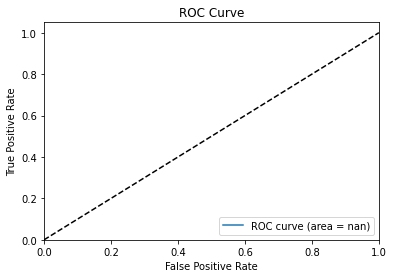

In [58]:
net = Net(train_img_size=IMG_SIZE, val_img_size=VAL_SIZE)#.load_from_checkpoint("lightning_logs\checkpoints\lightning_logs_Segmentation_14.ckpt", train_img_size=IMG_SIZE, val_img_size=VAL_SIZE)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer()

#  Run learning rate finder
lr_finder = trainer.tuner.lr_find(net)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()      

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
net.hparams.lr = new_lr

# Fit model
# trainer.fit(net)

In [ ]:
wandb.finish()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)